## *You need to finish code where "..." exists and add some Markdown cells to give answers based on the outputs when necessary*

In [23]:
# Helper function
import time

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func:{f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

# Question 1

In [24]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def func(X):
    x, y = X
    return x**4 - x**2 + y**2 + 2*x*y - 2

# calculates gradient (steepest descent algo)
def first_derivative(X):
    x, y = X
    df_dx = 4*x**3 - 2*x + 2*y
    df_dy = 2*y + 2*x 

    return [df_dx, df_dy]

def second_derivative(X):
    x, y = X
    df_dx2 = 12*x**2 - 2
    df_dy2 = 2

    return [df_dx2, df_dy2]

## (a)

*For debugging*: new point should be $(0.15,0.9)$

In [25]:
original_point = (1.5, 1.5)
new_point = (round(1.5 + first_derivative(original_point)[0] * -0.1, 2), round(1.5 + first_derivative(original_point)[1] * -0.1, 1))
if new_point == (0.15, 0.9):
    print("This is a good step")
else:
    print("This is a bad step")


This is a good step


### 1(a) Yes, this is a good step because I was able to achieve an evaluation that is lower than the starting point.  As long as my evaluation is not larger than the starting point, then it is a good step.  Because of this, I should increase my step_size by a factor of 1.2 again for the next time.  If I overshoot, I will decrease it by a factor of 0.5 and try again, not logging the point.

## (b)

*For debugging*: Take 41 steps to converge. Converge to point [-0.99999852,  0.99999607] with value -2.999999999985186.  took: 0.0020 sec

In [26]:
def steepest_descent(func, first_derivative, starting_point, step_size, tol):
    """
    Steepest Descent
    
    Parameters
    ----------
    func: Callable
        Function to be minimized
    first_derivative: Callable
        First derivative of the function to be minimized
    starting_point: np.ndarray
        Starting point of minimization
    step_size: float
        Size of each gradient descent step
    tol: float
        If the norm of the gradient is smaller than tol, the minimization will terminate
    
    Returns
    -------
    res: dict
        Optimization result
    """
    deriv = first_derivative(starting_point)
    count = 0
    visited = []
    while np.linalg.norm(deriv) > tol and count < 1e6:
        # calcualte new position
        new_point = starting_point - step_size * np.array(deriv)
        if func(new_point) < func(starting_point):
            # the step makes function evaluation smaller - it is a good step. what do you do?
            step_size *= 1.2
            visited.append(new_point)
            starting_point = new_point
        else:
            # the step makes function evaluation larger - it is a bad step. what do you do?
            step_size *= 0.5
        deriv = first_derivative(starting_point)
        count += 1
    return {
        "x": starting_point,
        "evaluation": func(starting_point),
        "path": np.array(visited),
        "nit": len(np.array(visited))
    }

Funtion for drawing path:

In [27]:
def draw_path(func, path, x_min=-2, x_max=2, y_min=-2, y_max=2):
    a = np.linspace(x_min, x_max, 100)
    b = np.linspace(y_min, y_max, 100)
    x, y = np.meshgrid(a, b)
    z = func((x, y))
    fig, ax = plt.subplots()
    contour = ax.contour(x, y, z, 50)
    plt.colorbar(contour)
    ax.plot(path[:, 0], path[:, 1], color='red')
    print("Length of the path:", np.sum(np.linalg.norm(np.diff(path, axis=0), axis=1)))

Length of the path: 2.009495827843268
Point converges to: [-0.99999852  0.99999607]
Valuation is: -2.999999999985186
Number of steps: 41


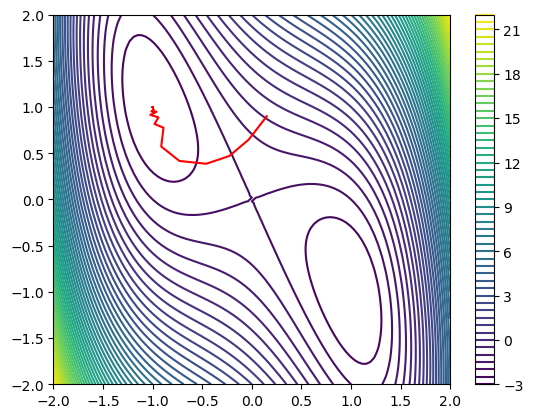

In [28]:
# optimization & draw path
res = steepest_descent(func=func, first_derivative=first_derivative, starting_point=np.array([1.5, 1.5]), step_size=0.1, tol=1e-5)
draw_path(func=func, path=res["path"])
print("Point converges to:", res["x"])
print("Valuation is:", res["evaluation"])
print("Number of steps:", len(res["path"]))

## (c)

In [29]:
# CG/BFGS optimization with scipy
from scipy.optimize import minimize

cg = minimize(func, [1.5, 1.5], method='CG', tol=1e-5)
bfgs = minimize(func, [1.5, 1.5], method='BFGS', tol=1e-5)

assert cg["success"] == True
assert bfgs["success"] == True
print("Steps from steepest descent:", len(res["path"]))
print("Steps from CG:", cg["nit"])
print("Steps from BFGS:", bfgs["nit"])


Steps from steepest descent: 41
Steps from CG: 9
Steps from BFGS: 7


### 1(c) Clearly, CG and BFGS converged in fewer steps (with success, as shown above with assert statements) than steepest descent. CG and BFGS are more efficient than steepest descents.

## Question 2

In [30]:
def Rosenbrock(X):
    x, y = X
    return (1 - x)**2 + 10*(y - x**2)**2

def Rosenbrock_grad(X):
    x, y = X
    df_dx = -2*(1-x) - 40*x*(y-x**2)
    df_dy = 20*(y-x**2)
    return [df_dx, df_dy]

## (a)

Minimum: [0.99999089 0.99998153]
Number of steps: 1204
Length of the path: 4.652767883462175


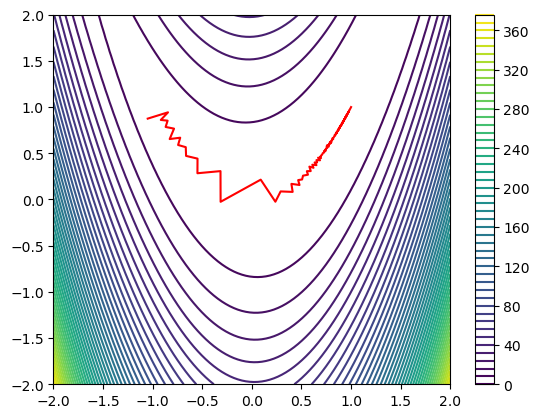

In [31]:
original_point = [-0.5, 1.5]
# SD minimization & draw path
sd_rosen = steepest_descent(func=Rosenbrock, first_derivative=Rosenbrock_grad, starting_point=original_point, step_size=0.1, tol=1e-5)
print("Minimum:", sd_rosen["x"])
print("Number of steps:", len(sd_rosen["path"]))
draw_path(func=Rosenbrock, path=sd_rosen["path"])

## (b)

In [32]:
def sgd(func, first_derivative, starting_point, step_size, tol, stochastic_injection=0):
    """
    Stochastic Gradient Descent
    
    Parameters
    ----------
    func: Callable
        Function to be minimized
    first_derivative: Callable
        First derivative of the function to be minimized
    starting_point: np.ndarray
        Starting point of minimization
    step_size: float
        Size of each gradient descent step
    tol: float
        If the norm of the gradient is smaller than tol, the minimization will terminate
    stochastic_injection: int
        Enable stochastic gradient (set to 1) or not (set to 0).
    
    Returns
    -------
    res: dict
        Optimization result
    """
    # evaluate the gradient of the starting point at first
    deriv = first_derivative(starting_point)
    count = 0
    visited = []
    while np.linalg.norm(deriv) > tol and count < 1e6:
        if stochastic_injection > 0:
            # formulate a stochastic_deriv (random vector) 
            # that is the same norm as your gradient 
            stochastic_deriv = np.random.normal(size=2)
            stochastic_norm = np.linalg.norm(stochastic_deriv)
            stochastic_deriv = stochastic_deriv / stochastic_norm * np.linalg.norm(deriv)
        else:
            stochastic_deriv = np.zeros(len(starting_point))
        
        direction = -(deriv + stochastic_injection * stochastic_deriv)
        # new position
        new_point = starting_point + step_size * direction
        if func(new_point) < func(starting_point):
            # good step
            visited.append(new_point)
            step_size *= 1.2
            starting_point = new_point
        else:
            # bad step
            step_size *= 0.5
        
        deriv = first_derivative(starting_point)
        count += 1
    return {
        "x": starting_point,
        "evaluation": func(starting_point),
        "path": np.array(visited),
        "nit": len(np.array(visited))
    }

*For debugging*: This is a stochastic method so your outputs may vary. For SGD, it takes ~1700 steps to converge and it takes ~0.1 sec

1709
Length of the path: 3.8867733167227256


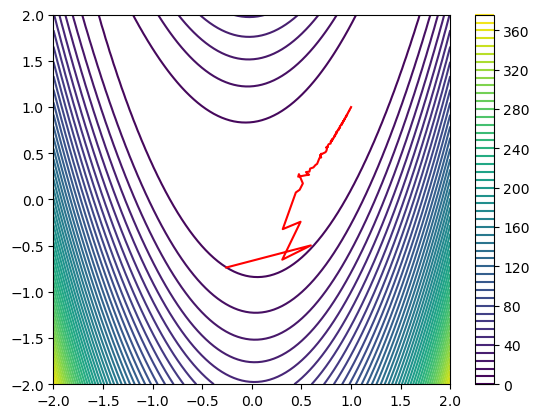

In [33]:
original_point = np.array([-0.5, 1.5])
# SGD optimization and draw path
sgd_res = sgd(func=Rosenbrock, first_derivative=Rosenbrock_grad, starting_point=original_point, step_size=0.1, tol=1e-5, stochastic_injection=1)
print(len(sgd_res["path"]))
draw_path(func=Rosenbrock, path=sgd_res["path"])

## (c)

In [34]:
# CG/BFGS with scipy
from scipy.optimize import minimize

cg = minimize(Rosenbrock, [-0.5, 1.5], method='CG', tol=1e-5)
bfgs = minimize(Rosenbrock, [-0.5, 1.5], method='BFGS', tol=1e-5)

assert cg["success"] == True
assert bfgs["success"] == True
print("Steps from stochastic gradient descent:", len(sgd_res["path"]))
print("Steps from CG:", cg["nit"])
print("Steps from BFGS:", bfgs["nit"])

Steps from stochastic gradient descent: 1709
Steps from CG: 20
Steps from BFGS: 22


## (d) In the case of SGD, you cannot draw conclusions with just one run.  The randomness of the stochastic vector means that there will almost never been two runs that are identical to each other.  Randomness is baked into the fundamentals of SGD.  In CG, BFGS, and steepest descent, these methods are not stochastic.  Therefore, they should always give out the same result as long as the hyperparameters and the starting point remains the same.  So, you can draw conclusions with just one run using CG, BFGS, and steepest descent.

## (e)

In [35]:
def statistics_test(algo, args, times, global_minimum=None, **kwargs):
    result = []
    for n in range(times):
        res = algo(*args, **kwargs)
        
        # If the norm of the differnce vector between the global minimum
        # and the resulting point is larger than 1e-3, the point will not
        # be considered as a global minimum
        if (global_minimum is not None) and (np.linalg.norm(res["x"] - global_minimum) > 1e-3):
            continue
        result.append(res)
    
    msg = f"Running {times} times: reach global minimum {len(result)} times"
    if len(result) > 0:
        avg = np.mean([run["nit"] for run in result]) # calculate the average
        std = np.std([run["nit"] for run in result]) # calculate the standard deviation
        msg += f", average {int(avg)} steps with variance {std:.2f}"
    print(msg)

starting_points = [
    original_point,
    np.array([0.0, 1.0]),
    np.array([-1.0, 1.0]),
    np.array([1.5, 0.5])
]

In [36]:
# test different minimization algorithms for different starting points
from scipy.optimize import minimize
for p in starting_points:
    print(f"Point being tested: {p}")
    print("Steepest descent:")
    stats_steep = statistics_test(steepest_descent, (Rosenbrock, Rosenbrock_grad, p, 0.1, 1e-5), times=10, global_minimum=[1, 1])
    print("SGD:")
    stats_sgd = statistics_test(sgd, (Rosenbrock, Rosenbrock_grad, p, 0.1, 1e-5, 1), times=10, global_minimum=[1, 1])
    print("CG:")
    stats_cg = statistics_test(algo=minimize, args=(Rosenbrock, p), times=10, global_minimum=[1, 1], method='CG', tol=1e-5)
    print("BFGS:")
    stats_bfgs = statistics_test(algo=minimize, args=(Rosenbrock, p), times=10, global_minimum=[1, 1], method='BFGS', tol=1e-5)
    print("---------------------------------")

Point being tested: [-0.5  1.5]
Steepest descent:
Running 10 times: reach global minimum 10 times, average 1204 steps with variance 0.00
SGD:
Running 10 times: reach global minimum 10 times, average 1749 steps with variance 56.77
CG:
Running 10 times: reach global minimum 10 times, average 20 steps with variance 0.00
BFGS:
Running 10 times: reach global minimum 10 times, average 22 steps with variance 0.00
---------------------------------
Point being tested: [0. 1.]
Steepest descent:
Running 10 times: reach global minimum 10 times, average 1204 steps with variance 0.00
SGD:
Running 10 times: reach global minimum 10 times, average 1751 steps with variance 86.22
CG:
Running 10 times: reach global minimum 10 times, average 13 steps with variance 0.00
BFGS:
Running 10 times: reach global minimum 10 times, average 13 steps with variance 0.00
---------------------------------
Point being tested: [-1.  1.]
Steepest descent:
Running 10 times: reach global minimum 10 times, average 1218 steps 

## 2(e) With the non-stochastic methods (CG, BFGS, steepest descent), we can see that there is never any variance regardless of the number of runs.  That's because they are non-random, and therefore, always output the same result (given static starting hyperparameters and starting point).  However, the biggest difference is that steepest descent is woefully inefficient, requiring nearly 12x more steps to achieve the same global minimum as CG and BFGS.  That's because CG and BFGS are quasi-second order methods, whereas steepest descent uses first-order.  The Hessian provides much more information about curvature, which better informs the next step.  With stochastic methods (SGD), there is always variance because of the random stochastic vector.  With randomness, we also see that performance is poor - even worse than steepest descent.  It is possible that the randomness of the method is forcing the algorithm to "dance" around the global minimum, without reaching it quickly.

# Question 3

In [37]:
def Camel(X):
    x, y = X
    return 2*x**2 - 1.05*x**4 + x**6/6 + x*y + y**2

def Camel_grad(X):
    x, y = X
    df_dx = 4*x - 4.2*x**3 + x**5 + y
    df_dy = x + 2*y
    return [df_dx, df_dy]

## (a)

In [38]:
original_point = np.array([-1.5, -1.5])

starting_points = [
    original_point,
    np.array([0.0, 1.0]),
    np.array([-1.0, 1.0]),
    np.array([1.5, 0.5])
]

In [39]:
# test different minimization algorithms for different starting points
for p in starting_points:
    print(f"Point being tested: {p}")
    print("SGD:")
    camel_sgd = statistics_test(sgd, (Camel, Camel_grad, p, 0.1, 1e-5, 1), times=100, global_minimum=[0, 0])
    print("CG:")
    camel_cg = statistics_test(algo=minimize, args=(Camel, p), times=100, global_minimum=[0, 0], method='CG', tol=1e-5)
    print("BFGS:")
    stats_bfgs = statistics_test(algo=minimize, args=(Camel, p), times=100, global_minimum=[0, 0], method='BFGS', tol=1e-5)
    print("---------------------------------")


Point being tested: [-1.5 -1.5]
SGD:


Running 100 times: reach global minimum 61 times, average 33 steps with variance 7.12
CG:
Running 100 times: reach global minimum 0 times
BFGS:
Running 100 times: reach global minimum 0 times
---------------------------------
Point being tested: [0. 1.]
SGD:
Running 100 times: reach global minimum 100 times, average 34 steps with variance 7.35
CG:
Running 100 times: reach global minimum 100 times, average 6 steps with variance 0.00
BFGS:
Running 100 times: reach global minimum 100 times, average 7 steps with variance 0.00
---------------------------------
Point being tested: [-1.  1.]
SGD:
Running 100 times: reach global minimum 49 times, average 38 steps with variance 7.38
CG:
Running 100 times: reach global minimum 0 times
BFGS:
Running 100 times: reach global minimum 0 times
---------------------------------
Point being tested: [1.5 0.5]
SGD:
Running 100 times: reach global minimum 14 times, average 37 steps with variance 7.56
CG:
Running 100 times: reach global minimum 0 times
BFGS

## Yes, it certainly appears that SGD is the only algorithm that converged. Only when the x value was already 0, and therefore only needed y-scaled optimization, did the CG and BFGS find the global minimum alongside SGD.  Otherwise, SGD, while inefficient at times, managed to find global minimum much more reliably.

## (b)

*For debugging*: This is a stochastic method so your outputs may vary. For SGDM, it takes ~200 steps to converge and it takes ~0.02 sec

In [40]:
def sgdm(func, first_derivative, starting_point, step_size, tol, stochastic_injection=0, momentum=0):
    """
    Stochastic Gradient Descent with Momentum
    
    Parameters
    ----------
    func: Callable
        Function to be minimized
    first_derivative: Callable
        First derivative of the function to be minimized
    starting_point: np.ndarray
        Starting point of minimization
    step_size: float
        Size of each gradient descent step
    tol: float
        If the norm of the gradient is smaller than tol, the minimization will terminate
    stochastic_injection: int
        Enable stochastic gradient (set to 1) or not (set to 0).
    momentum: float
        Momentum (eta) value in SGDM algorithm
    
    Returns
    -------
    res: dict
        Optimization result
    """
    deriv = first_derivative(starting_point)
    count = 0
    visited = []
    previous_direction = np.zeros(len(starting_point))
    while np.linalg.norm(deriv) > tol and count < 1e6:
        if stochastic_injection > 0:
            # formulate a stochastic_deriv (random vector) 
            # that is the same norm as your gradient 
            stochastic_deriv = np.random.normal(size=2)
            stochastic_norm = np.linalg.norm(stochastic_deriv)
            stochastic_deriv = stochastic_deriv / stochastic_norm * np.linalg.norm(deriv)
        else:
            stochastic_deriv = np.zeros(len(starting_point))
        
        # new direction
        direction = -(deriv + stochastic_injection*stochastic_deriv)
        # calculate new point, don't forget momentum!
        new_point = starting_point + step_size * direction - momentum*np.array(previous_direction)

        if func(new_point) < func(starting_point):
            # good step
            visited.append(new_point)
            step_size *= 1.2
            starting_point = new_point
        else:
            # bad step
            if step_size < 1e-5:
                # step size too small, zero out the previous direction
                # since we know it is a bad direction
                previous_direction = np.zeros(len(starting_point))
            else:
                step_size *= 0.5
                previous_direction = deriv
        count += 1
        deriv = first_derivative(starting_point)
    return {
        "x": starting_point,
        "evaluation": func(starting_point),
        "path": np.array(visited),
        "nit": len(visited)
    }

In [41]:
# test SGDM
for p in starting_points:
    print(f"Point being tested: {p}")
    print("SGD:")
    camel_sgd = statistics_test(sgd, (Camel, Camel_grad, p, 0.1, 1e-5, 1), times=10, global_minimum=[0, 0])
    print("CG:")
    camel_cg = statistics_test(algo=minimize, args=(Camel, p), times=10, global_minimum=[0, 0], method='CG', tol=1e-5)
    print("BFGS:")
    stats_bfgs = statistics_test(algo=minimize, args=(Camel, p), times=10, global_minimum=[0, 0], method='BFGS', tol=1e-5)
    print("SGDM:")
    stats_sgdm = statistics_test(sgdm, (Camel, Camel_grad, [-1.0, 1.0], 0.1, 1e-5, 1, 0.9), times=10, global_minimum=[0, 0])
    print("---------------------------------")


Point being tested: [-1.5 -1.5]
SGD:
Running 10 times: reach global minimum 5 times, average 40 steps with variance 12.20
CG:
Running 10 times: reach global minimum 0 times
BFGS:
Running 10 times: reach global minimum 0 times
SGDM:
Running 10 times: reach global minimum 4 times, average 231 steps with variance 39.75
---------------------------------
Point being tested: [0. 1.]
SGD:
Running 10 times: reach global minimum 10 times, average 34 steps with variance 5.24
CG:
Running 10 times: reach global minimum 10 times, average 6 steps with variance 0.00
BFGS:
Running 10 times: reach global minimum 10 times, average 7 steps with variance 0.00
SGDM:
Running 10 times: reach global minimum 5 times, average 224 steps with variance 39.65
---------------------------------
Point being tested: [-1.  1.]
SGD:
Running 10 times: reach global minimum 3 times, average 36 steps with variance 4.03
CG:
Running 10 times: reach global minimum 0 times
BFGS:
Running 10 times: reach global minimum 0 times
SGD

## It seems that SGD did better than SGDM in this case.  Both algorithms were still miles better than CG and BFGS, which did not converge in most cases.  SGD converged about as much as SGDM, but SGD did it with much fewer steps and with much less variance.  SGD seems to be the best minimizing algorithm for the Camel function.  However, only in the last point tested (1,5, 0.5) did SGDM do much better than SDM, converging 40 more times, albeit in more steps. In some cases, SGDM will do better than SGD, so it is always worth trying.